# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    %run "S7-cca-bounds.ipynb"

    print('Done')

the variable `GoodDataList` contains the session names
Done


# Part 1

functions that plot each panel.


---

monkey population CCA plot

In [2]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [7]:
@utility.report
def plot_monkey_cca(ax, ax_hist, full_list_MCx, allDFs_MCx):
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2 = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # lower bound
    len_trial = int(np.round(np.diff(monkey_defs.WINDOW_exec)/monkey_defs.BIN_SIZE))
    single_FileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            single_FileList1.append((I,J))
    n_iter = params.n_iter * 10
    side1df = [allDFs_MCx[i] for i,_ in single_FileList1]
    side2df = [allDFs_MCx[j] for _,j in single_FileList1]
    AllData1 = monkey_defs._get_data_array(side1df, epoch_L=len_trial, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData1_ = monkey_defs._get_data_array(side2df, epoch_L=len_trial, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData1_):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 50, axis=1).T

    # Upper bound
    single_FileList1 = []
    for I, _ in enumerate(full_list_MCx):
        single_FileList1.append(I)
    side1df = [allDFs_MCx[i] for i in single_FileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate(AllData1):
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 50, axis=1).T

    # plotting
    x_ = np.arange(1,monkey_defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,monkey_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    ax.text(x=monkey_defs.n_components, y=1, s= f'$n={CCsL.shape[1]}$ pairs of sessions\nacross $3$ monkeys',
           ha='right', va='top', fontsize=mpl.rcParams['xtick.labelsize'])
    
    #plot the hist

    bins = np.arange(0,1,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')
    
    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,-.05))

Executed: `plot_monkey_cca` in 299.9s


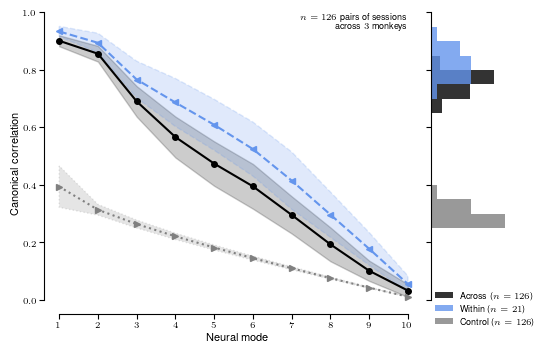

In [8]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    
    # full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca(ax,ax_, full_list_MCx, allDFs_MCx)
    
    plt.show()

---

Mouse CCA plot

In [3]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [14]:
@utility.report
def plot_mouse_cca(ax, ax_hist, allDFs_M1):
    defs = mouse_defs
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # upper bound
    AllData1 = dt.get_data_array(allDFs_M1, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    n_iter = params.n_iter * 10
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for sessionData in AllData1:
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 50, axis=1).T

    # lower bound
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, df2 in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))

    AllData1 = dt.get_data_array(side1df, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            time_idx = params.rng.integers(min_time-len_trial)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,...][:,:,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,...][:,:,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 50, axis=1).T


    #====================================PLOTTING
    
    x_ = np.arange(1,defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    ax.text(x=defs.n_components, y=1, s= f'$n={CCsL.shape[1]}$ pairs of sessions\nacross $4$ mice',
            ha='right', va='top', fontsize=mpl.rcParams['xtick.labelsize'])

    #plot the hist

    bins = np.arange(0,1,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'($n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')
    
    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,-0.05))

Executed: `get_full_mouse_data` in 0.8s
Executed: `plot_mouse_cca` in 9.1s


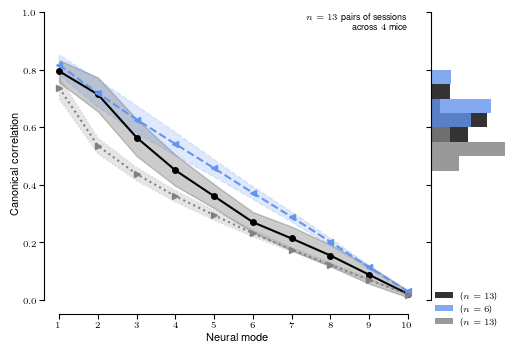

In [15]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    allDFs_M1, allDFs_Str = get_full_mouse_data()
    
    plot_mouse_cca(ax,ax_, allDFs_M1)
    
    plt.show()

# Part 2
Plot figure

Executed: `get_full_monkey_data` in 26.4s
Executed: `plot_monkey_cca` in 323.4s
Executed: `get_full_mouse_data` in 0.7s
Executed: `plot_mouse_cca` in 8.9s


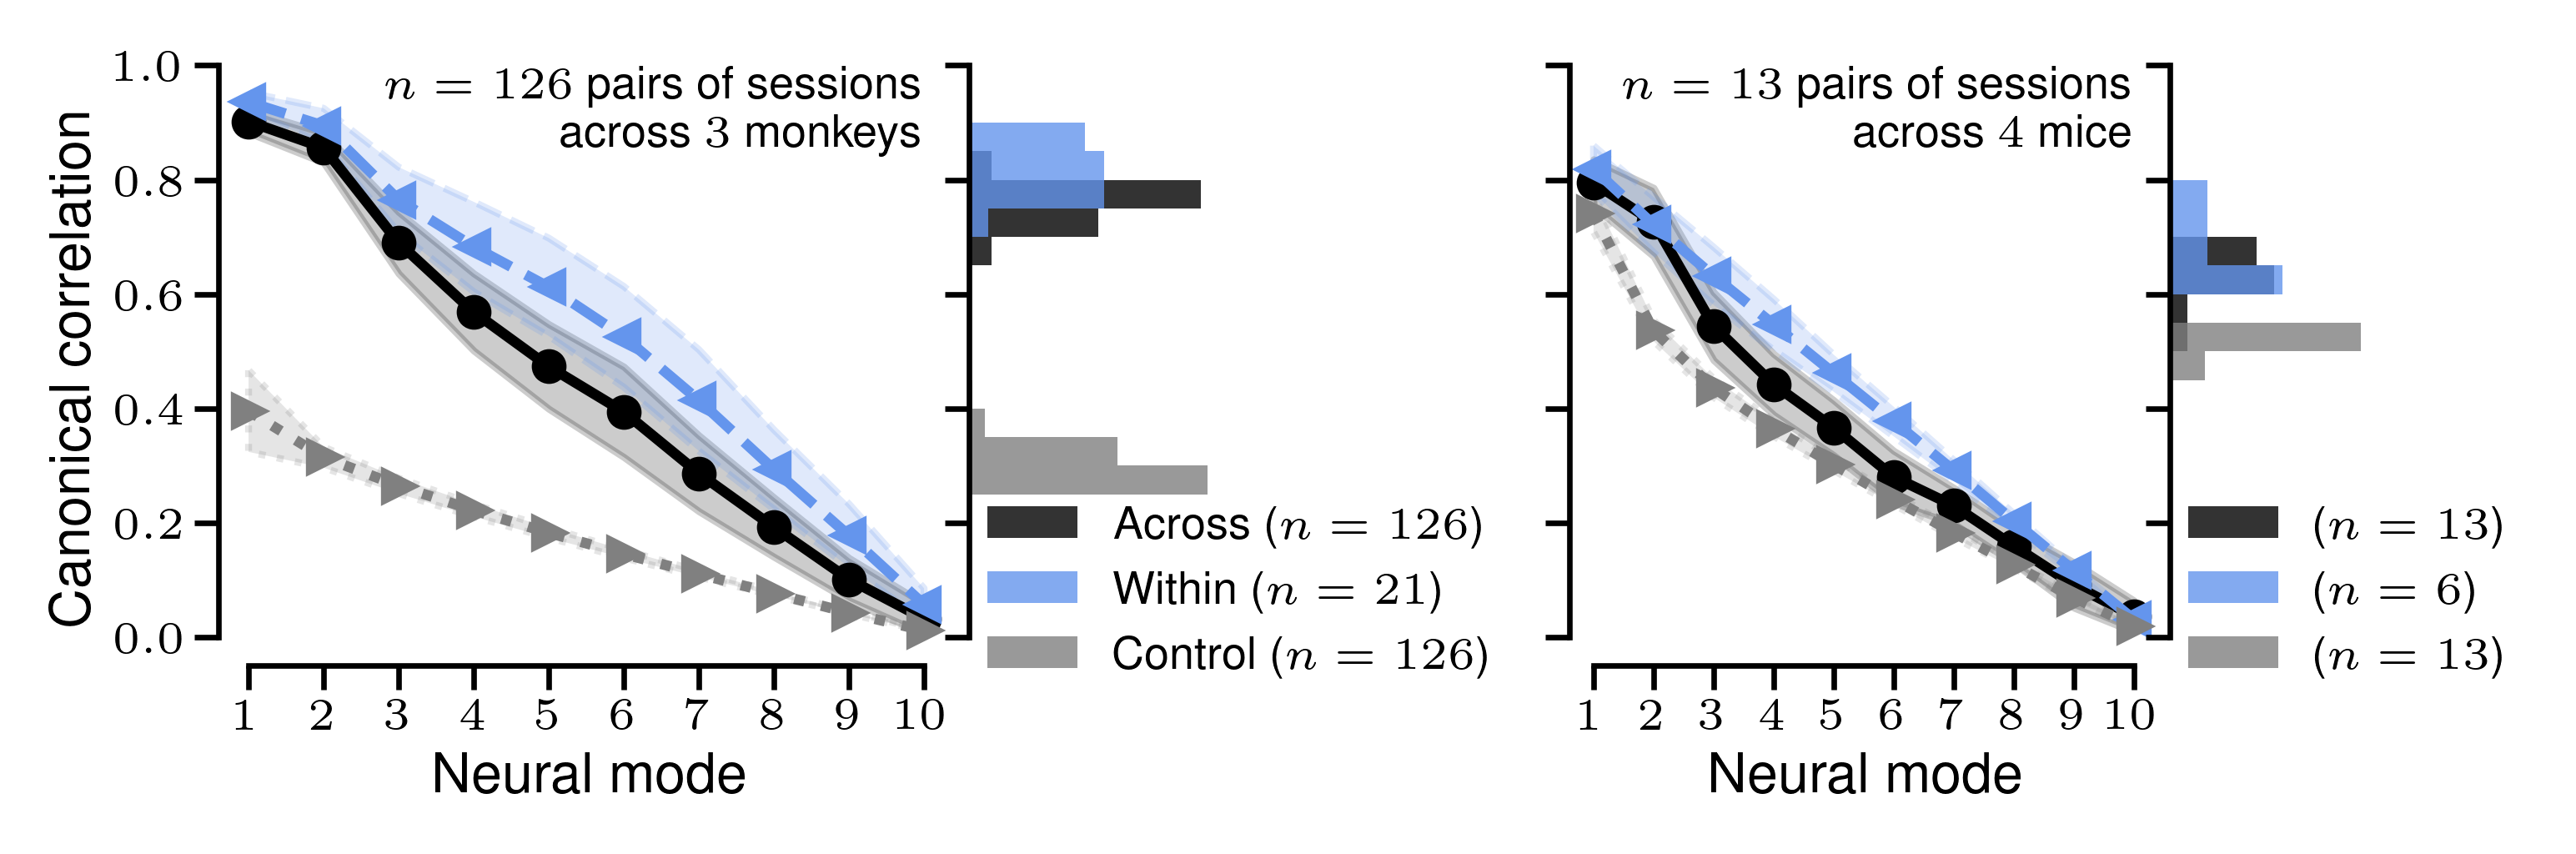

In [2]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize= (params.LargeFig[0], params.panels.SmallH)
    fig=plt.figure(figsize=figsize)
    
   

    ##########################################
    # 1: Monkey CCA
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=2,
                                    bottom=0, left=0,
                                    width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                                    width=params.panels.cca_hist[0],
                                    height=params.panels.cca_hist[1],
                                    wspace=0)

    ax1 = fig.add_subplot(gs1[0])
    ax1_ = fig.add_subplot(gs1[1])
    
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca(ax1,ax1_, full_list_MCx, allDFs_MCx)

    
    
    ##########################################
    # 2: MOUSE CCA
    gs2 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs1.right+(.7/figsize[0]),  # .3" offset
                           right=gs1.right+ (.3/figsize[0]) + params.panels.cca_hist[0]/figsize[0],
                           bottom=gs1.bottom,
                           top=gs1.top,
                           wspace=0)

    ax2 = fig.add_subplot(gs2[0])
    ax2_ = fig.add_subplot(gs2[1])
    
    allDFs_M1, _ = get_full_mouse_data()
    plot_mouse_cca(ax2,ax2_, allDFs_M1)
    ax2.set_ylabel('')
    ax2.set_yticklabels([])

    
    
    
#     fig.align_ylabels([ax1,ax4])
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # AXES=(ax1,ax2,ax3,ax4,ax5,ax6)
    # OFFX=np.array([.02]*len(AXES))
    # OFFY=np.array([.03]*len(AXES))
    # OFFX[[-1]]=0.12
    # OFFX[[1]]=0.06
    
    # params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)

    fig.savefig(params.figPath / 'figureS7-cca-bounds.pdf', format='pdf', bbox_inches='tight')